## Practicum 2: EDA and Statistical Analysis

In this practicum, you will work with data from the Federal Aviation Administration Wildlife Strike DatabaseLinks to an external site. which contains records of reported strikes to civil aircraft in the United States from 1990 to 2024. These incidents have resulted in the loss of lives and machinery. Various analyses shows increased incidents are attributed to environmental factors, changes to wildlife population, increases in the number of aircraft, among other factors.

The dataset contains aircraft, and a description of the wildlife incident that occurred. The data contains approximately 100 fields but I guarantee that you will only need about 15% of those columns. After reviewing the requirements for the practicum, you are welcome and encourage to drop any columns that are not needed for your analysis. For more information on the dataset and to learn more about the description of the fields, visit the following websiteLinks to an external site..

You are given the task of performing a comprehensive analysis of this dataset, perform hypothesis and statistical tests. Ensure that you explain all questions.

Group Members:
- Sydney
- Matthew
- Sohini
- Ian

In [67]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import os 
os.getcwd()

'/Users/moofie111/ds3000/practicum 2'

Data: Bird_Strikes_1990_2023.csv Download Bird_Strikes_1990_2023.csv-- This csv file contains data from 1990 - 2023

Data Dictionary: Description of the Data.pdfLinks to an external site. 

In [70]:
filepath = 'data/Bird_Strikes_1990_2023.csv'

## Question 1
- In your own words, formulate the Data Science problem that you were given.


We have been provided with a comprehensive dataset detailing bird strikes involving various types of aviation vehicles. This dataset encompasses a wide range of attributes associated with each incident, including but not limited to the species of bird involved, the phase of flight during which the strike occurred, and the specific location of the damage sustained. Our primary objective is to conduct a thorough analysis of this data to uncover and understand the intricate relationships between these various attributes. By doing so, we aim to gain deeper insights into the underlying causes of bird strikes. Ultimately, our goal is to identify effective strategies and recommendations for mitigating these incidents, enhancing aviation safety and reducing the risks associated with unplanned wildlife interaction on flights.

## Question 2
- Load the data using pandas and inspect it.


In [75]:
bird_strikes_df = pd.read_csv(filepath, low_memory=False)

- Perform the initial inspection of the data, its shape, types, etc.

In [77]:
# Get shape of dataframe
print("Shape of dataframe:", bird_strikes_df.shape)

# Check for null values in each column
null_counts = bird_strikes_df.isnull().sum()
print("\nColumns with null values:")
for column, count in null_counts.items():
    if count > 0:
        print(f"{column}: {count} null values")

Shape of dataframe: (288810, 100)

Columns with null values:
TIME: 125177 null values
TIME_OF_DAY: 122416 null values
AIRPORT_ID: 6 null values
LATITUDE: 35501 null values
LONGITUDE: 35502 null values
RUNWAY: 69958 null values
STATE: 35501 null values
FAAREGION: 35501 null values
LOCATION: 254871 null values
ENROUTE_STATE: 283773 null values
OPID: 26 null values
REG: 116267 null values
FLT: 159561 null values
AMA: 83335 null values
AMO: 98651 null values
EMA: 96659 null values
EMO: 102054 null values
AC_CLASS: 81917 null values
AC_MASS: 82320 null values
TYPE_ENG: 82766 null values
NUM_ENGS: 82551 null values
ENG_1_POS: 83329 null values
ENG_2_POS: 97198 null values
ENG_3_POS: 275730 null values
ENG_4_POS: 285520 null values
PHASE_OF_FLIGHT: 110967 null values
HEIGHT: 140003 null values
SPEED: 194573 null values
DISTANCE: 100576 null values
SKY: 149428 null values
PRECIPITATION: 277635 null values
AOS: 274614 null values
COST_REPAIRS: 283770 null values
COST_OTHER: 284050 null values
C

- Evaluate the dataset and perform at least three type of data preparation and justify the approach that is taken to prepare the data for analysis. Data prep can include, but is not limited to: handling missing values, data types, duplicates, etc. You will need to ensure that your data preparation addressed issues in at least 7 fields in the data.


Let's first convert the INCIDENT_DATE column to a datetime object so that we can perform time series analysis on it.

In [80]:
bird_strikes_df['INCIDENT_DATE'] = pd.to_datetime(bird_strikes_df['INCIDENT_DATE'])

Lets look at some of the cost information associated with the bird strike reports. We can probably assume for the strike reports that involve null values for costs, the cost was probably zero.



In [82]:
bird_strikes_df.fillna({'COST_REPAIRS_INFL_ADJ ': 0,
                         'COST_REPAIRS_ADJ ': 0,
                           'COST_REPAIRS_INFL ': 0,
                             'COST_REPAIRS ': 0},
                               inplace=True)

Its probably safe to assume for categories like number of injuries/fatalities, if there was no number recorded, the number of injuries/fatalities was likely zero.

We can use this logic to fill in the missing values for the number of injuries/fatalities column.


In [84]:
bird_strikes_df['NR_INJURIES'] = bird_strikes_df['NR_INJURIES'].fillna(0)
bird_strikes_df['NR_FATALITIES'] = bird_strikes_df['NR_FATALITIES'].fillna(0)

Another thing I can see in the data dictionary is the following for the AC_MASS column:

- 1 = 2,250 kg or less 
- 2 = ,2251-5700 kg 
- 3 = 5,701-27,000 kg 
- 4 = 27,001-272,000 kg 
- 5 = above 272,000 kg

we should replace those values with strings to make visualizations using this categorical variable easier to understand.

In [86]:
bird_strikes_df['AC_MASS'] = bird_strikes_df['AC_MASS'].replace({1: '2,250 kg or fewer', 
                                                                 2: ',2251-5700 kg', 
                                                                 3: '5,701-27,000 kg', 
                                                                 4: '27,001-272,000 kg', 
                                                                 5: 'above 272,000 kg'})

I also see that for the damage column the data dictionary specificies how we should handle the missing values:

- missing: Unknown
- N: No damage
- M: Minor damage
- S: Substantial damage
- D: Destroyed

We can use this to fill in the missing values for the damage column and then convert the column to their corresponding string values.

In [88]:
bird_strikes_df['DAMAGE_LEVEL'] = bird_strikes_df['DAMAGE_LEVEL'].fillna('Unknown')
bird_strikes_df['DAMAGE_LEVEL'] = bird_strikes_df['DAMAGE_LEVEL'].replace({'N': 'No damage', 
                                                               'M': 'Minor damage',
                                                               'M?': 'Undetermined Level', 
                                                               'S': 'Substantial damage', 
                                                               'D': 'Destroyed'})

I also see that there are about 35000 rows in the dataset that have null values for the latitude and longitude columns, which are important for visualizing the location of the bird strikes, considering the size of the dataset (about 288,000 rows), this would not be an insignificant amount of data to drop.

We should create another dataframe that contains important information pertaining to location, and drop the null values there instead.

In [90]:
location_df = bird_strikes_df[['STATE', 'FAAREGION', 'AIRPORT_ID', 'LATITUDE', 'LONGITUDE', 
                               'HEIGHT', 'SPEED', 'PHASE_OF_FLIGHT', 'SKY', 'DISTANCE', 'PRECIPITATION',
                               'RUNWAY', 'TIME_OF_DAY', 'TIME']]
location_df.isnull().sum()

STATE               35501
FAAREGION           35501
AIRPORT_ID              6
LATITUDE            35501
LONGITUDE           35502
HEIGHT             140003
SPEED              194573
PHASE_OF_FLIGHT    110967
SKY                149428
DISTANCE           100576
PRECIPITATION      277635
RUNWAY              69958
TIME_OF_DAY        122416
TIME               125177
dtype: int64

Let's drop the 35000 null values



In [92]:
location_df = location_df.dropna(subset=['LATITUDE', 'LONGITUDE'])
print(f"Shape of location_df: {location_df.shape}")
location_df.head()

Shape of location_df: (253308, 14)


,STATE,FAAREGION,AIRPORT_ID,LATITUDE,LONGITUDE,HEIGHT,SPEED,PHASE_OF_FLIGHT,SKY,DISTANCE,PRECIPITATION,RUNWAY,TIME_OF_DAY,TIME
0,CA,AWP,KSMF,38.69542,-121.59077,0.0,NaN,Take-off Run,NaN,0.0,NaN,NaN,NaN,NaN
1,CO,ANM,KDEN,39.85841,-104.66700,0.0,NaN,Take-off Run,NaN,0.0,NaN,NaN,NaN,NaN
2,NE,ACE,KOMA,41.30252,-95.89417,0.0,NaN,Take-off Run,NaN,0.0,NaN,NaN,NaN,NaN
3,DC,AEA,KIAD,38.94453,-77.45581,1000.0,NaN,Approach,NaN,NaN,NaN,NaN,NaN,NaN
4,NY,AEA,KLGA,40.77724,-73.87261,5000.0,NaN,Climb,NaN,NaN,NaN,NaN,NaN,NaN


Now we have a dataframe that contains information about the location of the bird strikes without null latitude or longitude values, which will be useful for geospatial analysis while also maintaining these rows in the original dataframe.


In [94]:
counts = bird_strikes_df['SPECIES'].value_counts()
counts


SPECIES
Unknown bird - small     48901
Unknown bird - medium    38259
Unknown bird             24839
Mourning dove            14578
Barn swallow              9679
                         ...  
Lilac-crowned parrot         1
Chicken turtle               1
Spectacled caiman            1
Red-necked stint             1
Ravens                       1
Name: count, Length: 912, dtype: int64

- Prepare meaningful* summary statistics for 3 continuous variables and 3 categorical variables.


** Note: meaningful summary statistics explains the statistical summary of relevant fields in a coherent manner.

### Brief Statistical Summary of 3 Categorical and 3 Continuous Variables

Continuous Variables:

- Cost of Repair
- Height of Collision
- Speed of Aircraft

Categorical Variables:

- Damage Level
- Phase of Flight
- Time of Day

### Continuous

In [98]:
# Cost of Repair Analysis:
print("Statistical Analysis of Repair Costs:")
print("\n .describe() Statistics:")
print(bird_strikes_df['COST_REPAIRS'].describe())
print("\nMost Common Repair Costs:")
print(bird_strikes_df['COST_REPAIRS'].value_counts().head(10))

Statistical Analysis of Repair Costs:

 .describe() Statistics:
count          5040
unique         1304
top       10,000.00
freq            193
Name: COST_REPAIRS, dtype: object

Most Common Repair Costs:
COST_REPAIRS
10,000.00     193
5,000.00      182
1,000.00      160
2,000.00      141
500.00        141
15,000.00     138
20,000.00     137
50,000.00     128
30,000.00     109
100,000.00    106
Name: count, dtype: int64


What we can see, is that across our 5000 or so data points, it is most common for repair costs to be about $10000, with the bulk of repairs costing between $500 and $15000. However, for 106 strikes, the associated repair cost was $100,000, making it the 10th most common cost of repair. Suggesting that overall, the costs are often relatively low, but there are significant numbers of strikes that result in much higher costs.

In [100]:
# Statistical Analysis of Height of Collision:
print("Statistical Analysis of Height of Collision:")
print("\n .describe() Statistics:")
print(bird_strikes_df['HEIGHT'].describe())
print("\nMost Common Height of Collision:")
print(bird_strikes_df['HEIGHT'].value_counts().head(10))

Statistical Analysis of Height of Collision:

 .describe() Statistics:
count    148807.000000
mean        865.960358
std        1843.098801
min           0.000000
25%           0.000000
50%          50.000000
75%         900.000000
max       31300.000000
Name: HEIGHT, dtype: float64

Most Common Height of Collision:
HEIGHT
0.0       63300
100.0      6511
50.0       5818
500.0      5116
200.0      5019
1000.0     4916
300.0      3881
10.0       3617
2000.0     3513
3000.0     3468
Name: count, dtype: int64


From this statistical summary, we can conclude that for strikes in our dataset, it is most common for them to occur on the ground. We can also see that strikes occur most often during the takeoff and landing parts of the flight, as the second and third most common heights of strike are 100ft and 50ft respectively. Although the data points are most densely packed near the ground, there are still significant numbers of strikes occurring much higher, with the 10th most common height being 3000ft.

In [102]:
# Statistical Analysis of Speed of Aircraft:
print("Statistical Analysis of Speed of Aircraft:")
print("\n .describe() Statistics:")
print(bird_strikes_df['SPEED'].describe())
print("\nMost Common Speed of Aircraft:")
print(bird_strikes_df['SPEED'].value_counts().head(10))

Statistical Analysis of Speed of Aircraft:

 .describe() Statistics:
count    94237.000000
mean       142.585057
std         46.650050
min          0.000000
25%        120.000000
50%        140.000000
75%        160.000000
max       1250.000000
Name: SPEED, dtype: float64

Most Common Speed of Aircraft:
SPEED
140.0    10222
130.0     7275
120.0     7044
150.0     6323
100.0     5873
135.0     4636
250.0     4171
160.0     3878
180.0     3386
110.0     3184
Name: count, dtype: int64


This analysis reveals a weaker correlation between aircraft speed and the frequency of bird strikes. However, there appears to be a notable range of speeds, specifically between 120 and 150 mph, where strikes are more common. Interestingly, there was one instance recorded of a bird strike occuring at an astonishing speed of 1250 mph (Poor bird). Additionally, the previous height analysis indicated that most collisions occur at ground level, and the majority of recorded speeds during these incidents fall between 100 and 250 mph, suggesting that these strikes typically happen while the aircraft is taxiing.

### Categorical

In [105]:
# Damage Level Analysis:
print("Statistical Analysis of Damage Level:")
print("\n .describe() Statistics:")
print(bird_strikes_df['DAMAGE_LEVEL'].describe())
num_categories = bird_strikes_df['DAMAGE_LEVEL'].nunique()
print(f"Number of unique categories: {num_categories}")
print("\nMost Common Damage Levels:")
print(bird_strikes_df['DAMAGE_LEVEL'].value_counts().head(6))

Statistical Analysis of Damage Level:

 .describe() Statistics:
count        288810
unique            6
top       No damage
freq         167573
Name: DAMAGE_LEVEL, dtype: object
Number of unique categories: 6

Most Common Damage Levels:
DAMAGE_LEVEL
No damage             167573
Unknown               101495
Minor damage            8578
Undetermined Level      6821
Substantial damage      4261
Destroyed                 82
Name: count, dtype: int64


Looking at the damage level category distribution, we can see that it is relatively uncommon for a strike to result in damage to an aircraft, but when it does damamge can range from minor to catastrophic.

In [107]:
# Phase of Flight Analysis:
print("Statistical Analysis of Phase of Flight:")
print("\n .describe() Statistics:")
print(bird_strikes_df['PHASE_OF_FLIGHT'].describe())
num_categories = bird_strikes_df['PHASE_OF_FLIGHT'].nunique()
print(f"Number of unique categories: {num_categories}")
print("\nMost Common Phases of Flight:")
print(bird_strikes_df['PHASE_OF_FLIGHT'].value_counts().head(num_categories))

Statistical Analysis of Phase of Flight:

 .describe() Statistics:
count       177843
unique          11
top       Approach
freq         75224
Name: PHASE_OF_FLIGHT, dtype: object
Number of unique categories: 11

Most Common Phases of Flight:
PHASE_OF_FLIGHT
Approach        75224
Landing Roll    32157
Take-off Run    30248
Climb           26957
En Route         5308
Departure        2933
Descent          2331
Local            1150
Arrival           753
Taxi              667
Parked            115
Name: count, dtype: int64


What this statistical summary provides is confirmation of some of our previous guesses about the most common times for strikes to occur. The data suggests that most strikes happen while the aircraft is either apporaching or leaving the the airport, with most strikes happening during these transition phases.

In [109]:
# Time of Day Analysis:
print("Statistical Analysis of Time of Day:")
print("\n .describe() Statistics:")
print(bird_strikes_df['TIME_OF_DAY'].describe())
num_categories = bird_strikes_df['TIME_OF_DAY'].nunique()
print(f"Number of unique categories: {num_categories}")
print("\nMost Common Times of Day:")
print(bird_strikes_df['TIME_OF_DAY'].value_counts().head(num_categories))

Statistical Analysis of Time of Day:

 .describe() Statistics:
count     166394
unique         4
top          Day
freq      102548
Name: TIME_OF_DAY, dtype: object
Number of unique categories: 4

Most Common Times of Day:
TIME_OF_DAY
Day      102548
Night     50446
Dusk       7428
Dawn       5972
Name: count, dtype: int64


From this analysis, we can see that the time that birds strikes seem to occur the least is in the morning, with dawn being the least common time of day for a strike to occur. Day and night dominate as they are the longest periods of time, but a higher prevalence of strikes during the dusk compared to the dawn suggests that birds are most active in the later hours of the day.

## Question 3

 Perform an in-depth analysis by creating visualizations to understand the distribution and relationships within the data, while ensuring that your analysis and explanation of the results tell a story. It's important to select appropriate visualizations based on the type of data. Explain all results.

- Evaluate the distribution of bird strikes in each state and display the top 20 states.



In [114]:
# Initialize a function for plotting the top X of a category based on frequency of bird strikes

def plot_top_column(df, column_name=None, num_states=20, graph_title=None):
    state_counts = df[column_name].value_counts()
    state_counts = state_counts.sort_values(ascending=False)

    plt.figure(figsize=(12, 8))
    sns.barplot(x=state_counts.head(num_states).index, 
                y=state_counts.head(num_states),
                hue=state_counts.head(num_states),
                palette='Pastel2',
                zorder=10)
    plt.xlabel(f'{column_name}')
    plt.ylabel('Number of Bird Strikes')    
    plt.title(f'Top {num_states} {graph_title} with the Highest Number of Bird Strikes')
    plt.xticks(state_counts.head(num_states).index, rotation=45, fontsize=8)
    plt.grid(True, zorder=0, alpha=0.4)
    plt.legend().remove()
    plt.tight_layout()
    plt.show()

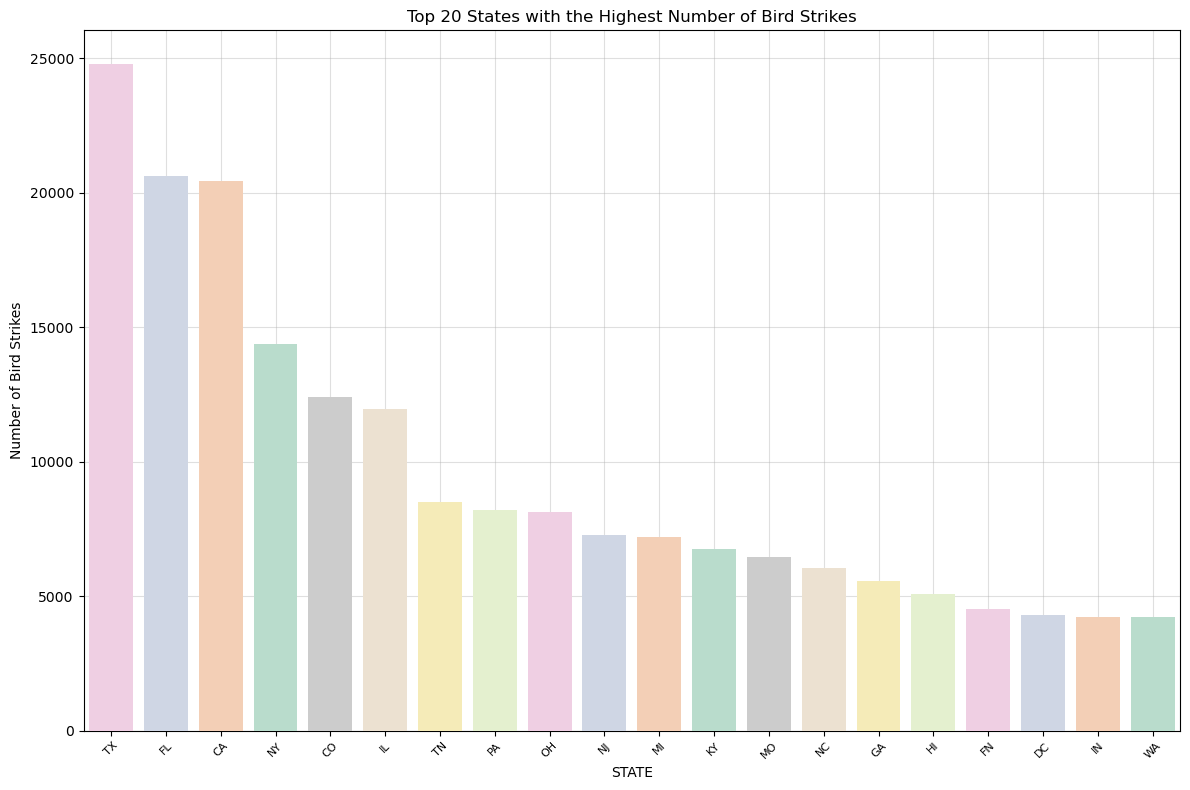

In [115]:
plot_top_column(bird_strikes_df, 'STATE', 20, 'States')

It seems that the states with either large surface area or higher air traffic density have the highest number of bird strikes. Texas, California, Florida, and Colorado are all large states with large tourism industries, and likely have a higher number of bird strikes due to the sheer number of aircrafts in the area. New York is the smllest state in the top 5, but it is home to some of the most trafficked airports in the world, including JFK, LaGuardia, and Newark. Its proximity to the ocean also allows for more and different species of birds to be present. 

- What is the most common bird species that are involved in bird strikes?



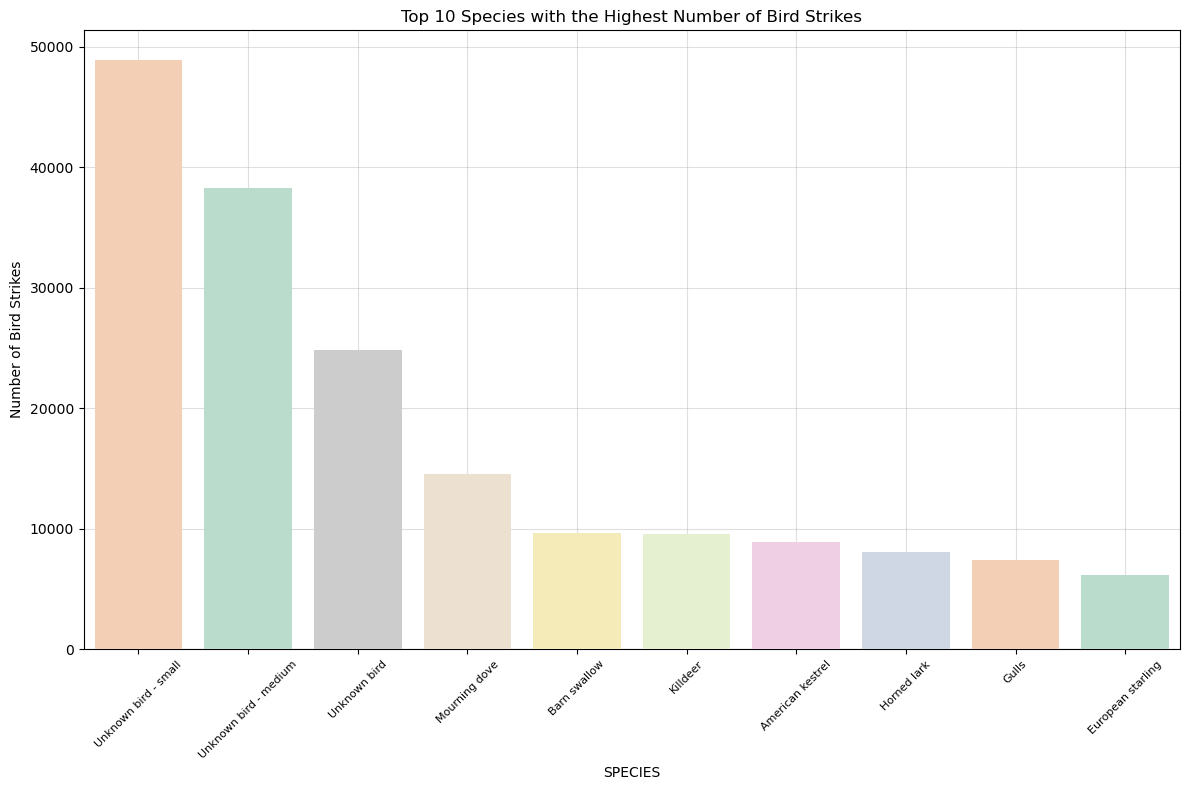

In [119]:
plot_top_column(bird_strikes_df, 'SPECIES', 10, 'Species')

The most common birds 'species' are all categoeries of birds based on the pilots' judgement of incidents. The most common known species is the Mourning dove, followed closely by the Barn Swallow, and the Killdeer. While these are the most commonly identified birds by pilots, it is important to note that substantially larger number of birds strikes are attributed to unknown species, so we cannot make the claim that mourning doves are most likely to hit planes.

- Perform a comparative analysis of the annual aircraft damage for each phase of flight. Evaluate the results over the last 10 years to determine what patterns exist. Note: this requires a year over year analysis.


In [128]:
# Convert to datetime and filter for past 10 years
cutoff_date = pd.to_datetime('2014-01-01')
past_10_years = bird_strikes_df[pd.to_datetime(bird_strikes_df['INCIDENT_DATE']) >= cutoff_date].sort_values(by='INCIDENT_DATE')
past_10_years.reset_index(drop=True, inplace=True)
# initialize a new years column to simplify the time series analysis
past_10_years['YEAR'] = pd.to_datetime(past_10_years['INCIDENT_DATE']).dt.year

# Now lets pivot this data to get counts for damages for each phase of flight by year
damage_by_phase = pd.pivot_table(
    past_10_years,
    values='INDEX_NR',  # Using INDEX_NR to count occurrences
    index=['YEAR', 'PHASE_OF_FLIGHT'],
    columns=['DAMAGE_LEVEL'],
    aggfunc='count',
    fill_value=0
)
damage_by_phase.head(20)
# add a new column that excludes 'no damage' from the damage total
damage_by_phase['Damage Total'] = damage_by_phase[['Minor damage', 'Undetermined Level', 'Substantial damage', 'Destroyed']].sum(axis=1)
damage_by_phase.head(15)


DAMAGE_LEVEL          Destroyed  Minor damage  No damage  Substantial damage  \
YEAR PHASE_OF_FLIGHT                                                           
2014 Approach                 0           112       3169                  63   
     Arrival                  0             0         33                   2   
     Climb                    1            54        968                  43   
     Departure                0             2        130                   1   
     Descent                  0             2         78                   0   
     En Route                 0            26        181                  15   
     Landing Roll             0            34       1277                  14   
     Local                    0             0         22                   0   
     Parked                   0             0          1                   0   
     Take-off Run             0            21        938                  24   
     Taxi                     0             0         24                   0   
2015 Approach                 0           115       3162                  34   
     Arrival                  0             1         34                   0   
     Climb                    0            46        937                  42   
     Departure                0             1        191                   1   

DAMAGE_LEVEL          Undetermined Level  Unknown  Damage Total  
YEAR PHASE_OF_FLIGHT                                             
2014 Approach                         56      159           231  
     Arrival                           0        7             2  
     Climb                            26      117           124  
     Departure                         1       50             4  
     Descent                           0        3             2  
     En Route                          7       10            48  
     Landing Roll                     10      130            58  
     Local                             2       34             2  
     Parked                            0        0             0  
     Take-off Run                      9      234            54  
     Taxi                              0        5             0  
2015 Approach                         67       95           216  
     Arrival                           1        6             2  
     Climb                            40       80           128  
     Departure                         3       20             5

Perfect, now lets use this data to create a stacked bar chart to visualize the damage levels by phase of flight over the past 10 years.


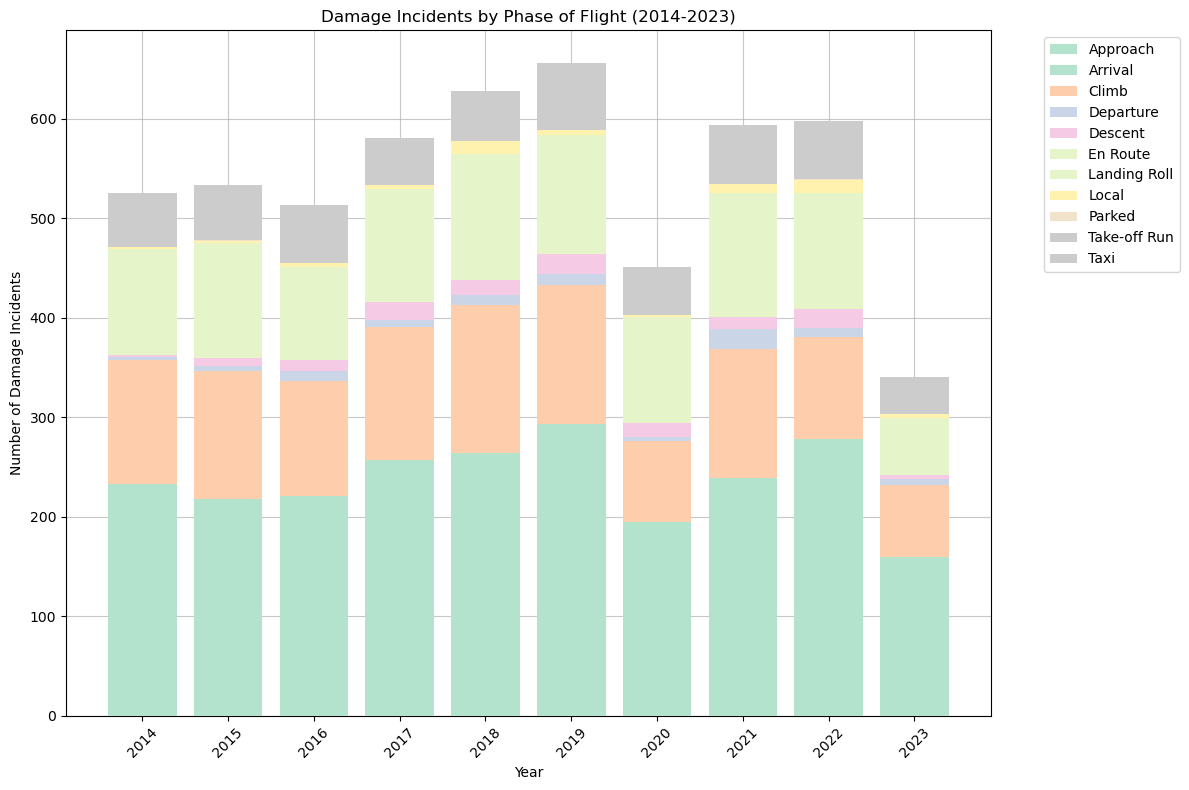

In [136]:
# Create a stacked bar plot showing damage totals over time for each phase of flight
plt.figure(figsize=(12, 8))

# isolate the data
damage_totals = damage_by_phase.reset_index()
years = damage_totals['YEAR'].unique()
phases = damage_totals['PHASE_OF_FLIGHT'].unique()

# get muted colors using pastel colormap
colors = plt.cm.Pastel2(np.linspace(0, 1, len(phases)))

# stacked bar plot
bottom = np.zeros(len(years))
for phase, color in zip(phases, colors):
    phase_data = damage_totals[damage_totals['PHASE_OF_FLIGHT'] == phase]
    plt.bar(phase_data['YEAR'], phase_data['Damage Total'], 
            bottom=bottom[phase_data['YEAR'].astype(int)-2014], 
            label=phase, color=color, zorder=10)
    bottom[phase_data['YEAR'].astype(int)-2014] += phase_data['Damage Total'].values

plt.title('Damage Incidents by Phase of Flight (2014-2023)')
plt.xlabel('Year')
plt.xticks(years, rotation=45)
plt.ylabel('Number of Damage Incidents')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.7, zorder=0)
plt.tight_layout()
plt.show()


We would assume that these strike frequencies might be proportional to the amount of time spend in each phase of flight, but we can see that this is not the case. En route is only the third most common phase of flight for strieks to occur, while appraoch and climb and number 1 and 2 respectively. This suggests that the number of strikes is not proportional to the amount of time spent in each phase of flight, but rather is dependent on other factors like the height and speed of the aircraft.


- Analyze the frequency of bird strike incidents that occur on a monthly basis over the last 10 years. Analyze the results to determine when these incidents are more prevalent.  This question requires you to drill deeper into the analysis to determine if the distribution has changed over the last 10 years. Note: this requires a year over year analysis.



Lets use a similar pivot table tactic to create a monthly analysis of the data, but instead we will use the proportion of total incidents that each month accounts for rather than aggregrate totals, to better visualize potential trends.

In [146]:
incidents_by_month = pd.pivot_table(
    past_10_years,
    values='INDEX_NR',
    index=['YEAR', 'INCIDENT_DATE'],
    aggfunc='count',
    fill_value=0
) # this is an initializing pivot that contains each unique instance of an incident per year w/ a datetime object associated with it 
monthly_totals = incidents_by_month.copy()
# this extracts the month from the datetime object initializes two indexes (month and year) and assigns numbers 1-12 to represent each month
monthly_totals.index = pd.MultiIndex.from_tuples(
    [(year, pd.to_datetime(date).month) for year, date in monthly_totals.index],
    names=['YEAR', 'MONTH']
)
# sum incidents by year and month
monthly_totals = monthly_totals.groupby(['YEAR', 'MONTH'])['INDEX_NR'].sum()


# Reshape the df to have months as columns, documentation below - this was new to me
monthly_totals = monthly_totals.unstack(level='MONTH')

month_names = {
    1: 'January', 2: 'February', 3: 'March', 4: 'April',
    5: 'May', 6: 'June', 7: 'July', 8: 'August',
    9: 'September', 10: 'October', 11: 'November', 12: 'December'
}
monthly_totals = monthly_totals.rename(columns=month_names)

monthly_totals.head(10)

MONTH,January,February,March,April,May,June,July,August,September,October,November,December
YEAR,,,,,,,,,,,,
2014,338.0,349.0,511.0,885.0,1307.0,1193.0,1870.0,1995.0,2016.0,1924.0,828.0,476.0
2015,399.0,407.0,645.0,1072.0,1387.0,1175.0,1809.0,1940.0,1774.0,1679.0,955.0,530.0
2016,472.0,468.0,607.0,996.0,1488.0,994.0,1635.0,1828.0,1739.0,1566.0,970.0,560.0
2017,443.0,454.0,682.0,1045.0,1441.0,1253.0,2088.0,2119.0,1939.0,1696.0,1102.0,514.0
2018,441.0,470.0,689.0,1130.0,1724.0,1314.0,1993.0,2276.0,2251.0,2351.0,1017.0,546.0
2019,464.0,552.0,778.0,1248.0,1797.0,1520.0,2224.0,2516.0,2285.0,2234.0,1168.0,555.0
2020,429.0,443.0,669.0,489.0,754.0,925.0,1721.0,1823.0,1674.0,1474.0,774.0,445.0
2021,419.0,441.0,604.0,1016.0,1533.0,1363.0,2136.0,2410.0,2156.0,1933.0,1004.0,623.0
2022,407.0,433.0,779.0,1267.0,1687.0,1414.0,2250.0,2457.0,2569.0,2216.0,1142.0,605.0


pandas unstack() method documentation:
 https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.unstack.html


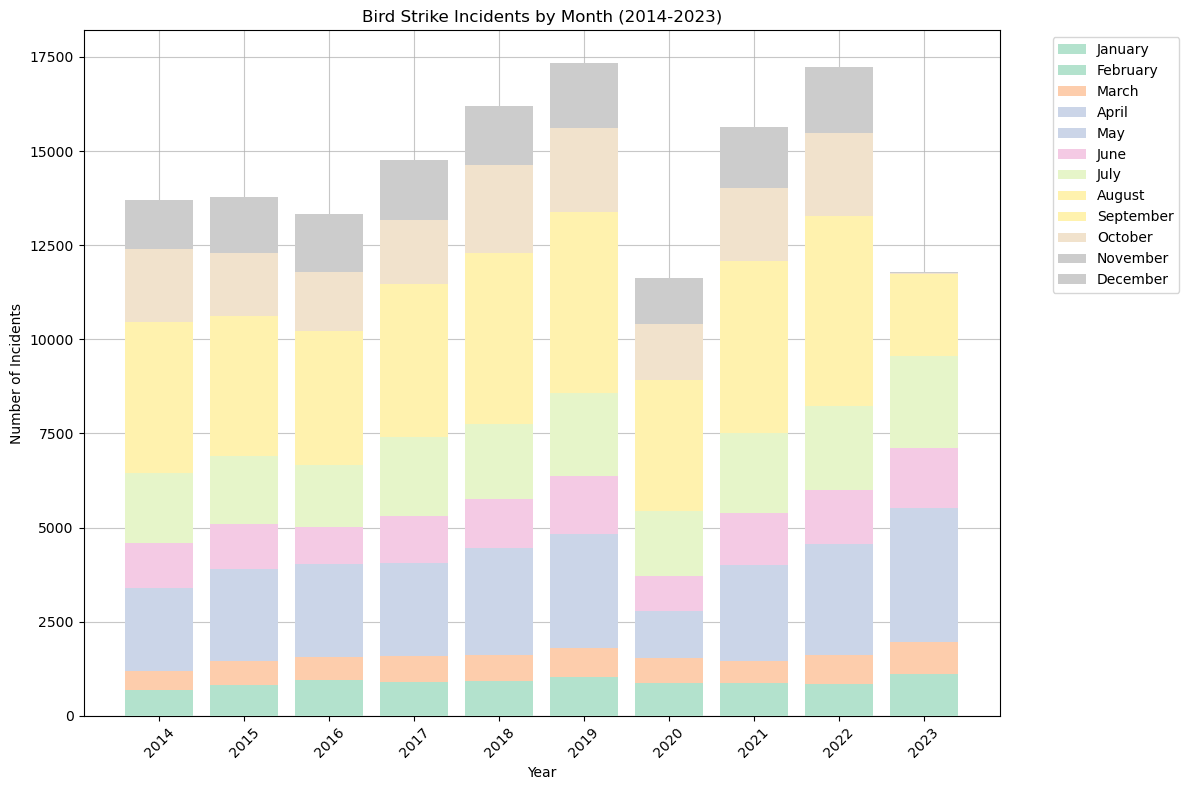

In [148]:
# Lets visualize the data in the same way we did for the damage levels by phase of flight
plt.figure(figsize=(12, 8))

# isolate the data
monthly_data = monthly_totals.reset_index()
years = monthly_data['YEAR'].unique()

# get pastel2 colors
colors = plt.cm.Pastel2(np.linspace(0, 1, 12))  # 12 months

# stacked bar plot
bottom = np.zeros(len(years))
for month_num, (month_name, color) in enumerate(zip(month_names.values(), colors), 1):
    month_data = monthly_data[['YEAR', month_name]]
    plt.bar(month_data['YEAR'], month_data[month_name], bottom=bottom, 
            label=month_name, color=color, zorder=10)
    bottom += month_data[month_name].values

plt.title('Bird Strike Incidents by Month (2014-2023)')
plt.xlabel('Year')
plt.xticks(years, rotation=45)
plt.ylabel('Number of Incidents')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.7, zorder=0)
plt.tight_layout()
plt.show()

What we can see from this graph, is that on an aggregate level, incidents spiked in 2019 and 2022, with down years in 2020 and 2023. The dip in 2020 was likely due to a decline in air traffic during the pandemic, while the dip in 2023 can likely be attributed to lack of data. We can also see that on a monthly level, the highest frequency of incidents seem to happen during migration periods for birds, (increasing number of travelling birds in March through May, with the highest traffic occuring between July and October).

These trends may be much easier to visualize if we put together a stacked bar chart base the on proportion of incidents occuring in each month relative to the total number of incidents for that year.

Alright, let's assign proportions to each month, i.e. month count / yearly total.

In [152]:
month_names = ('January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December')

In [154]:
# Calculate yearly totals
yearly_totals = monthly_totals.sum(axis=1)

# Calculate proportion for each month and initialize a new column for each month
for month in month_names:
    monthly_totals[month + '_Proportion'] = monthly_totals[month] / yearly_totals
|monthly_totals.head(10)

SyntaxError: invalid syntax (2727647597.py, line 7)

Now for visualization: 

In [ ]:
plt.figure(figsize=(12, 8))

# isolate the proportion data
monthly_data = monthly_totals.reset_index()
years = monthly_data['YEAR'].unique()
proportion_columns = [col for col in monthly_totals.columns if 'Proportion' in col]

# init x labels
yearly_totals = monthly_totals[[col for col in monthly_totals.columns if 'Proportion' not in col]].sum(axis=1)
x_labels = [f'{year}\nn={int(yearly_totals[year])}' for year in years] # included a sample size count for each year for a better understanding of the data

# get Pastel2 colors
colors = plt.cm.Pastel2(np.linspace(0, 1, len(proportion_columns)))

# stacked bar plot
bottom = np.zeros(len(years))
for month, color in zip(proportion_columns, colors):
    month_data = monthly_data[['YEAR', month]]
    plt.bar(month_data['YEAR'], month_data[month], bottom=bottom, 
            label=month.replace('_Proportion', ''), color=color, zorder=10)
    bottom += month_data[month].values

plt.title('Proportion of Bird Strike Incidents by Month (2014-2023)')
plt.xlabel('Year')
plt.xticks(years, x_labels, rotation=45)
plt.ylabel('Proportion of Yearly Incidents')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.7, zorder=0)
plt.tight_layout()
plt.show()


This visual makes our previous conclusions much more clear, and also exposes issues with the 2023 data more obviously. (No data after August)

- Perform ONE (1) additional analysis on the distribution. Ensure that you either : 
1) perform a comparative analysis by evaluating 3 or more groups within the data 

or 

2) perform a temporal analysis of the patterns over 10 or more years (this requires a year over year analysis of the patterns). 

Do not repeat any of the previous analysis.

I want to see how the total number of injuries + fatalities has changed over the course of the dataset.

First, I'll need to isolate the data I'll need into a new dataframe.

In [158]:
total_casualties_yearly = bird_strikes_df[['INCIDENT_YEAR', 'NR_INJURIES', 'NR_FATALITIES']].copy()
total_casualties_yearly['TOTAL_CASUALTIES'] = total_casualties_yearly['NR_INJURIES'] + total_casualties_yearly['NR_FATALITIES']
total_casualties_yearly = total_casualties_yearly.groupby('INCIDENT_YEAR').sum().reset_index()
total_casualties_yearly['YEAR'] = total_casualties_yearly['INCIDENT_YEAR'].astype(int)
total_casualties_yearly.index = total_casualties_yearly['YEAR']
total_casualties_yearly = total_casualties_yearly.drop(columns=['INCIDENT_YEAR', 'YEAR'])
total_casualties_yearly.head(10)

,NR_INJURIES,NR_FATALITIES,TOTAL_CASUALTIES
YEAR,,,
1990,8.0,0.0,8.0
1991,11.0,0.0,11.0
1992,8.0,1.0,9.0
1993,5.0,1.0,6.0
1994,22.0,2.0,24.0
1995,8.0,0.0,8.0
1996,15.0,0.0,15.0
1997,17.0,0.0,17.0
1998,16.0,2.0,18.0


Let's plot this data to see how the total number of casualties has changed over time.

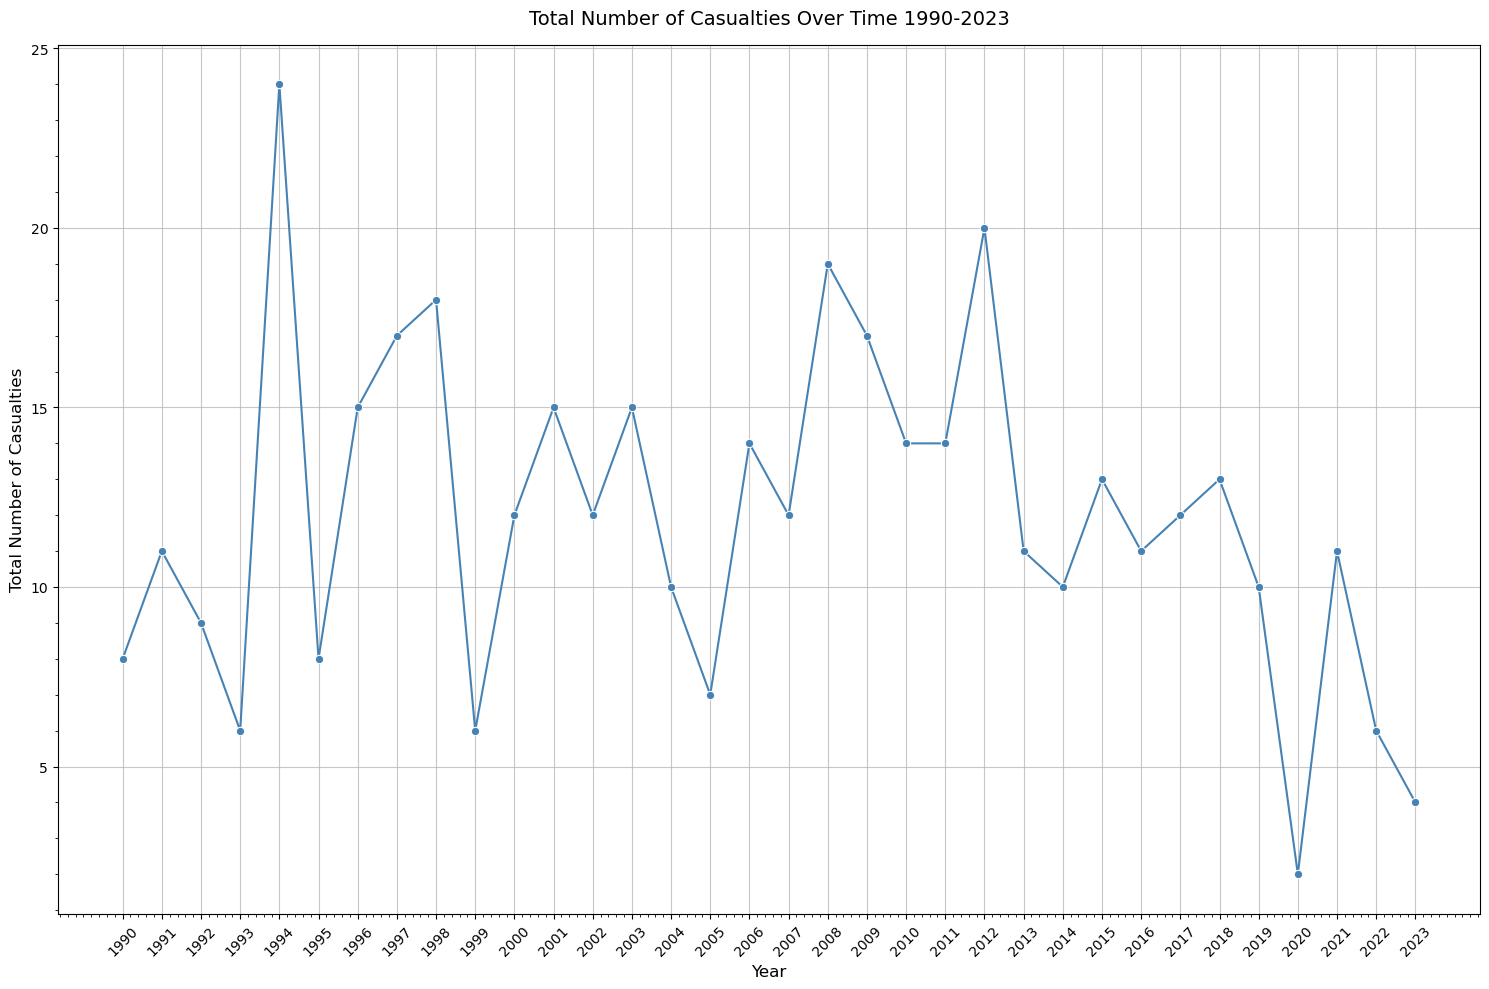

In [161]:
plt.figure(figsize=(15, 10))
sns.lineplot(data=total_casualties_yearly, 
            x=total_casualties_yearly.index, 
            y='TOTAL_CASUALTIES', 
            marker='o', 
            color='steelblue')
plt.title('Total Number of Casualties Over Time 1990-2023', fontsize=14, pad=15)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Total Number of Casualties', fontsize=12)
plt.grid(True, alpha=0.7)
plt.minorticks_on()
plt.xticks(total_casualties_yearly.index, rotation=45)
plt.tight_layout()
plt.show()

This provides an interesting look at the number of casualties over time, with the highest number of casualties being record in 1994 (24), and the lowest numbers occuring in 2020, for likely pandemic related reasons. On an optimistic note, despite earlier analysis suggesting that bird strikes are still very prevalent, in recent years casualties have been on a downward trend.

## Question 4

- Perform pairwise analysis of select features and evaluate the significance of the pattern or trend. A suitable value for alpha is 5%. Explain all results.

- Create a scatterplot that shows the relationship between aircraft height and speed. Evaluate the correlation, the strength and the significance of the results.

- Visualize the distribution of the aircraft speed during: 1) the approach phase of flight and 2) the landing roll phase of flight. Perform a 2 sample t-test and evaluate if there is a statistical difference between the speed during these two flight phases. Tip: if the data is skewed, you will need to address this prior to the statistical analysis.

- Create a visualization of the aircraft damage grouped by phase of flight.
Evaluate if the results are statistically significant. Ensure that you use the appropriate test.
Perform ONE (1) additional statistical test.
- Explain what you are testing and the reason this information is useful.
Visualize the data, state the hypothesis and explain if it is statistically significant.

## Question 5

Explore a simple linear relationship* within the data and create a model to predict the occurrence of bird strikes in a given FAA region. Ensure that you explain all results.

- Extract all data for the AWP FAA Region and use a line chart to visualize the frequency of incidents between 1990 and 2015 inclusive.

- Using the extracted data above, create a simple linear regression model and predicts the incidents for 2016 and 2017.

- Display the r-squared and what this indicates about your model's ability to fit the data.

- Visualize the dataset from (1) and include the predicted results for 2016 and 2017.
Compare and contrast the predictions for 2016 and 2017 with the actual values.
Perform predictions for 2018 through to 2020. Explain what transpired when your model was used to predict this time period. Comment on the reliability of your model.



*Tip: It is important to remember that you are creating a simple linear regression model, which is limited in features and does not include information about all factors that influence the frequency of bird strikes. Keep this in mind while framing your response and explanations.

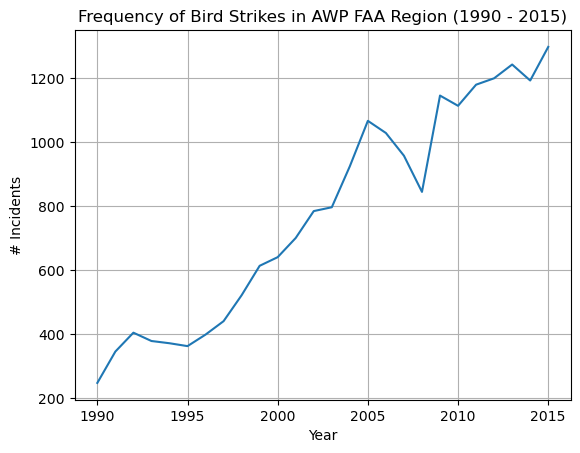

In [166]:
# filter through original data set to only get bird strikes in AWP FAA region from 1990 to 2015
awp_faa_data = bird_strikes_df[(bird_strikes_df['FAAREGION'] == 'AWP') & (bird_strikes_df['INCIDENT_YEAR'].between(1990, 2015))]

# sort by year and incident count
awp_incident_count = awp_faa_data.groupby('INCIDENT_YEAR').size().reset_index(name='Incidents')

# plot incidents by year from 1990 to 2015
plt.plot(awp_incident_count['INCIDENT_YEAR'], awp_incident_count['Incidents'])
plt.xlabel("Year") # label x axis
plt.ylabel("# Incidents") # label y axis
plt.title("Frequency of Bird Strikes in AWP FAA Region (1990 - 2015)") # label chart
plt.grid(True) # show grids for better visualization
plt.show()

The chart above shows the frequency of bird strikes in the AWP FAA region from years 1990 to 2015 inclusive. Overall, the chart has had an upward trend since 1990. 

In [169]:
from sklearn.linear_model import LinearRegression

X = awp_incident_count['INCIDENT_YEAR'].to_numpy() # get the explanatory variable
X = X.reshape(-1, 1)

y = awp_incident_count['Incidents'].to_numpy()  # get the response variable
y = y.reshape(-1, 1)

lr_model = LinearRegression(fit_intercept=True) # initialize the regression model
lr_model = lr_model.fit(X, y)                   # fit the data to the model i.e. find the line of best fit

# display the parameters for the slope and intercept
print('The intercept is: ', lr_model.intercept_[0])
print('The slope is: ', lr_model.coef_[0,0])

The intercept is:  -86667.52307692304
The slope is:  43.667350427350414


In [170]:
# get r-squared, i.e. the coefficient of determination
r_sqrd = lr_model.score(X, y)
r_sqrd = round(r_sqrd, 2)

print('r-squared is: ', r_sqrd)

r-squared is:  0.95


The value of r-squared is 0.95, and this tells us the model is very reliable for finding trends, since 95% of the data is correct. It also tells us that it can be incorrect, as shown below in our predictions. The model cannot account for external factors. 

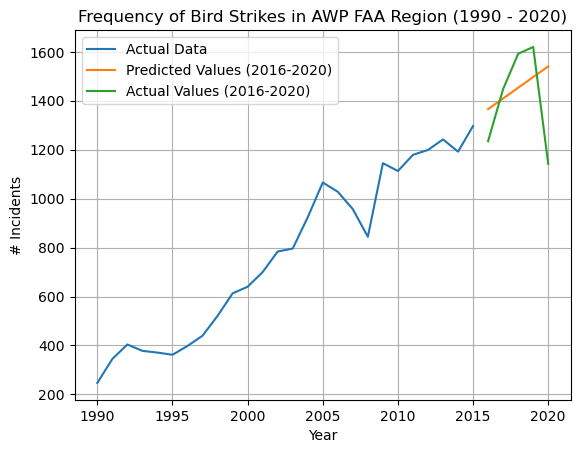

In [174]:
# predict 2016-2020
future_years = np.array([2016, 2017, 2018, 2019, 2020]).reshape(-1, 1)
predictions = lr_model.predict(future_years)

# get the actual data for 2016-2020
actual_data = bird_strikes_df[(bird_strikes_df['FAAREGION'] == 'AWP') & (bird_strikes_df['INCIDENT_YEAR'].isin([2016, 2017, 2018, 2019, 2020]))]
actual_incidents = actual_data.groupby('INCIDENT_YEAR').size().reset_index(name='Incidents')

# visualize original dataset alongside model's predictions
plt.plot(awp_incident_count['INCIDENT_YEAR'], awp_incident_count['Incidents'], label="Actual Data") # plot data for original years
plt.plot(future_years, predictions, label='Predicted Values (2016-2020)') # plot predictions
plt.plot(actual_incidents['INCIDENT_YEAR'], actual_incidents['Incidents'], label='Actual Values (2016-2020)') # plot actual values

plt.xlabel("Year") # label x axis
plt.ylabel("# Incidents") # label y axis
plt.title("Frequency of Bird Strikes in AWP FAA Region (1990 - 2020)") # label chart
plt.legend()
plt.grid(True) # show grids for better visualization
plt.show() # show chart

The graph above represents the frequency of bird strikes in the AWP FAA region from 1990-2020. Past 2015, there are prediction and actual values for years 2016-2020. We see that the predictions are a straight upwards trending line throughout the years, whereas the actual values look like an upside down v. While the simple linear regressio model was correct in predicting values for the first half of those years, it was wrong for the second half. This is because it will always be an upwards trending line. 

Our simple linear regression model is reliable when there are no external factors affecting the topic. Since linear regression models are limited in features and does not include all influential factors, our model is not fully reliable and can only be used as a baseline predictor. 

## Question 6

Summarize the overall analysis for questions 1 through 5 and share THREE (3) key findings.

## Question 7 - Optional

This optional bonus question requires that you perform a geospatial analysis on bird strikes and visualize the results using a map. Examples include (but you are not limited to):

- Mapping bird strike incidents: visualize the locations of bird strike incidents to identify hot spots or patterns

- Heat maps: create heat maps to show the density of bird strike incidents in different areas.

- Proximity Analysis: analyze the proximity of bird strikes to airports or landmarks etc

Ensure that you clearly indicate the analysis that you are performing and provide detailed steps to explain ALL findings from your analysis.

Note: a thorough analysis that demonstrates multiple patterns is required to earn full credit for this question.

I will be performing a geospatial analysis on mapping bird strike incidents. 

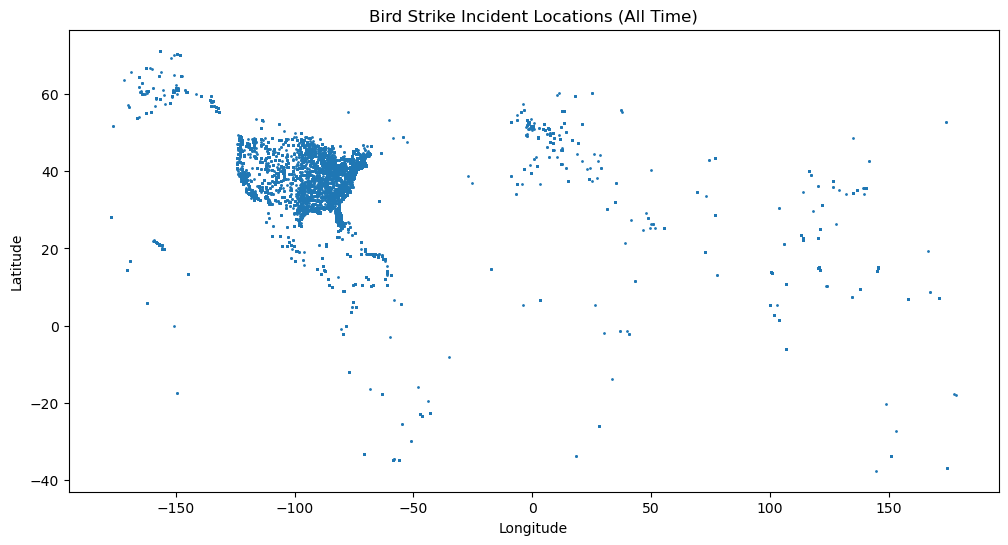

In [219]:
# load dataset with latitude, longitude, and incident year
geo_cols = ["LATITUDE", "LONGITUDE", "INCIDENT_YEAR"]
bird_strikes_geo_df = bird_strikes_df[geo_cols].dropna()

bird_strikes_geo_df = bird_strikes_geo_df[
    (bird_strikes_geo_df["LATITUDE"].between(-90, 90)) & 
    (bird_strikes_geo_df["LONGITUDE"].between(-180, 180))
]

# make map bigger
plt.figure(figsize=(12, 6))
plt.scatter(bird_strikes_geo_df["LONGITUDE"], bird_strikes_geo_df["LATITUDE"], s=1) # plot the incidents by location

plt.xlabel("Longitude") # label x axis
plt.ylabel("Latitude") # label y axis
plt.title("Bird Strike Incident Locations (All Time)") # label map
plt.show()

Based on the map above showing all bird strike incidents by latitude and longitude, we see that most of the incidents occur in the United States and the others scattered around the world. While most occur in the United States, we see some bunched up in other countries/continents such as Canada and Europe. Another pattern that I found was that most of these incidents occur over land, and not over wataer. 

Note:

- Ensure that all visualizations have a title and label both the x and y axes
- all numeric calculations should be rounded to 2 decimal places.
- Use markdown cells to explain your observations about the data.
- Include the names of all teammates on all submissions
- Ensure that your Python code is in a code cell and that it executes without errors.